In [1]:
import pandas as pd
import numpy as np

In [2]:
S_2019 = pd.read_csv('SpotifyAudioFeaturesApril2019.csv')
S_2019.shape

(130663, 17)

In [3]:
S_2018 = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')
S_2018.shape

(116372, 17)

In [173]:
df = pd.concat([S_2019, S_2018])
df = df.drop_duplicates()
df.shape

(222144, 17)

In [5]:
df[df['track_id'] == '4186GuHoIST964PyBNHwL4']

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
111431,Dillon Francis,4186GuHoIST964PyBNHwL4,Get It Get It,0.0107,0.589,168792,0.937,0.296,0,0.369,-4.81,0,0.128,161.99,4,0.776,40
100727,Dillon Francis,4186GuHoIST964PyBNHwL4,Get It Get It,0.0107,0.589,168792,0.937,0.296,0,0.369,-4.81,0,0.128,161.99,4,0.776,41


In [174]:
df = df.groupby(by=['track_id', 'track_name', 'artist_name']).mean()
df = df.reset_index()

In [175]:
df.shape

(131330, 17)

In [8]:
# normalize dataset
numeric_cols = df.select_dtypes(include=np.number).columns
df_num = df.select_dtypes(include=np.number)
df_norm = df.copy()
df_norm[numeric_cols] = (df_num - df_num.mean()) / df_num.std()

In [9]:
# create and fit model using available data

from sklearn.neighbors import NearestNeighbors

categoricals = ['track_id', 'track_name', 'artist_name']
misleading = ['key', 'time_signature', 'popularity', 'mode', 'tempo', 'duration_ms']

unwanted = categoricals + misleading

features = [col for col in df_norm.columns if col not in unwanted]
Model = NearestNeighbors(n_neighbors=10).fit(df_norm[features])

In [10]:
df_norm.head()

,track_id,track_name,artist_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,0009UBVA8DCDwk1Hepib6P,Kalifornia,PUSSYGANGCO,-0.775949,0.517763,-0.194038,-0.669688,-0.480427,1.323295,-0.590755,-0.586419,0.803300,-0.548888,0.150754,0.235150,-1.335373,-1.303863
1,000RDCYioLteXcutOjeweY,Teeje Week,Jordan Sandhu,-0.821959,0.512501,-0.182736,0.771061,-0.620673,-1.452378,-0.670045,0.982616,0.803300,0.627453,1.401243,0.235150,1.541881,1.311438
2,000TqGTOAZjAIFU6SjmFmc,Northern Star (ASOT 895),RAM,-0.990560,-0.961064,1.003543,1.262836,0.229133,-0.342109,0.143718,-0.136464,-1.244875,-0.303481,0.612801,0.235150,-1.493290,-0.100824
3,000v2QpqP2NmikGmSkLlCZ,Legado Del 20 (En Vivo),Panchito Arredondo,0.242057,1.412428,-0.635539,0.824849,-0.620641,-0.064541,-0.112632,0.484823,0.803300,0.579176,0.247368,-1.709822,1.561186,-0.283895
4,002QT7AS6h1LAF5dla8D92,Still Smell Like It,Young Dolph,-0.854947,1.307173,-0.039436,0.321547,-0.620673,-1.174810,-0.494177,0.713469,0.803300,0.587223,0.118051,0.235150,-0.817220,1.363744


In [11]:
# pick a song in the dataset to use as a test

song_index = 3679
id_info = ['track_id', 'artist_name', 'track_name']

# 
test_row = df_norm.iloc[song_index][features]
test_song = test_row.to_numpy()

# print id, artist, and title for convience
for identifier in id_info:
    print(f'{identifier}: ', df_norm.iloc[song_index][identifier])
#     print(df_norm.iloc[song_index][identifier])

track_id:  0DX2s5Xy2n8QI7gqcqZBXx
artist_name:  Ludwig van Beethoven
track_name:  Symphony No. 5, Op. 67 in C Minor: Symphony No. 5, Op. 67 in C Minor: Allegro con brio


In [12]:
# distance of each neighbor to the test song
# note the first will always be ZERO because the song 
# will always be it's own nearest neighbor with a distance
# of ZERO
Model.kneighbors(test_song.reshape(1,-1))[0][0]

array([0.        , 0.45162751, 0.45309734, 0.47096712, 0.52441654,
       0.53178252, 0.57737085, 0.59782588, 0.6159461 , 0.63232197])

In [13]:
# indexes of the nearest neighbors
recommend = Model.kneighbors(test_song.reshape(1,-1))[1][0]
recommend

array([  3679,  27382,  33632,  21812,   3241,  27718,  84961,  92404,
        55240, 123194])

In [132]:
# all the nearest neighbors

df_norm.iloc[recommend]

,track_id,track_name,artist_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
3679,0DX2s5Xy2n8QI7gqcqZBXx,"Symphony No. 5, Op. 67 in C Minor: Symphony No...",Ludwig van Beethoven,1.801766,-0.934751,1.598565,-1.821518,1.326105,-1.452378,0.286798,-2.014995,-1.244875,-0.539232,-0.583295,0.235150,-0.828803,-0.153130
27382,1cgDCP6umf8F17A8B0Xo3k,"Horn Concerto in E Major, K. 494a",Wolfgang Amadeus Mozart,1.850959,-0.792657,2.964497,-1.858017,1.203911,-0.342109,-0.112632,-1.975410,0.803300,-0.552106,0.234997,0.235150,-0.767026,-0.466966
33632,1zLD9Yn7fpr66yfnj6z9F0,"The Art of the Fugue: Contrapunctus 3, BWV 1080/3",Johann Sebastian Bach,1.885683,-1.087370,-0.042583,-1.626345,1.667694,0.490593,0.215258,-1.904646,-1.244875,-0.572221,-0.329237,2.180123,-0.786332,-0.702343
21812,1IFttuLqaDIZc2FBXCMHeM,"Piano Concerto No. 3, Op. 37: III. Rondo. Allegro",Ludwig van Beethoven,1.752573,-1.271565,2.810293,-1.687817,1.564940,-1.452378,0.185450,-1.954930,-1.244875,-0.631763,-0.282936,0.235150,-0.921468,-1.199251
3241,0BqzmrNsDOrBd2MClyd0ZA,"Bastien und Bastienne, K. 50 (Original 1768 Ve...",Wolfgang Amadeus Mozart,1.848065,-1.050531,-0.916496,-1.932168,1.531614,0.490593,-0.160325,-1.968380,0.803300,-0.566589,0.875449,0.235150,-0.782470,-0.545425
27718,1dsxtj7PXYC0Oc29ZUIujS,Plains,Cut Chemist,1.764147,-0.997903,-1.313716,-1.603293,1.342768,-0.342109,-0.124555,-2.032113,-1.244875,-0.379115,-1.358437,0.235150,-0.643473,-0.362354
84961,52nS9v6KqOdV3lu4rN96aQ,"交響曲 第 5番 ハ短調, 作品 67 運命: 3. Allegro",Ludwig van Beethoven,1.706273,-1.155785,0.494603,-1.891827,1.359431,0.768160,0.805460,-2.001851,0.803300,-0.536014,0.479006,-1.709822,-0.817220,-0.100824
92404,5UFQCjZvnhJolskqpxQyco,Hide and Seek,Pieter de Graaf,1.787297,-1.061056,-0.038152,-1.438087,1.734345,1.323295,0.406030,-2.024013,-1.244875,-0.601992,0.575853,0.235150,-0.732277,0.265318
55240,3H91omu3CIuyzB4wU9R3Xo,"Diabelli Variations, Op. 120: Variation 5. All...",Ludwig van Beethoven,1.868321,-1.161048,-1.263630,-1.710869,1.837100,-1.452378,0.256989,-2.208183,0.803300,-0.585095,-0.400811,-1.709822,-0.929190,-0.362354
123194,7JDYsvl6TM2ywTcX8jpvKO,Entr'acte (On The Sidewalk),Caroline Shaw,1.824915,-1.050531,-1.031199,-1.957909,1.820437,-0.619676,-0.017246,-1.862769,0.803300,-0.548888,-0.366483,0.235150,-0.743860,-0.362354


In [15]:
features

['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'valence']

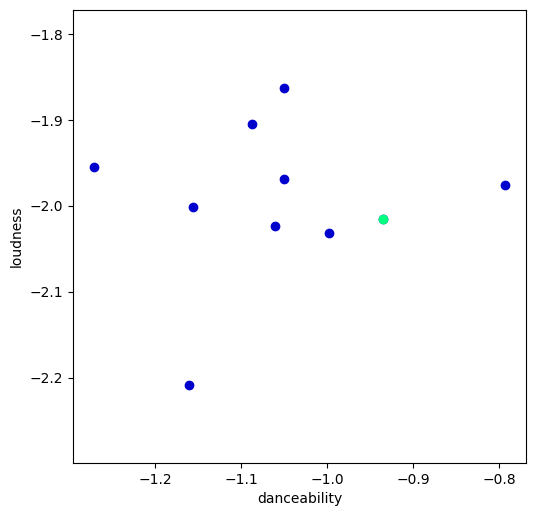

In [164]:
import matplotlib.pyplot as plt

feature_name_1 = 'danceability'
feature_name_2 = 'loudness'

# creates perfectly scaled, square graphs centered over the data.

x_min = df_norm.iloc[recommend][feature_name_1].min()
x_max = df_norm.iloc[recommend][feature_name_1].max()

y_min = df_norm.iloc[recommend][feature_name_2].min()
y_max = df_norm.iloc[recommend][feature_name_2].max()

x_diff = x_max - x_min
y_diff = y_max - y_min
if x_diff == y_diff:
    pass
elif x_diff < y_diff:
    x_min_old = x_min
    x_min = x_min_old + 0.5 * x_diff - 0.5 * y_diff
    x_max = x_max - 0.5 * x_diff + 0.5 * y_diff
elif y_diff < x_diff:
    y_min_old = y_min
    y_min = y_min_old + 0.5 * y_diff - 0.5 * x_diff
    y_max = y_max - 0.5 * y_diff + 0.5 * x_diff
    
# applies the custom fit x and y boundaries and scales the plot
fig = plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='pink')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# fig = plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='b')
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)

plt.axis('scaled')
plt.xlabel(f'{feature_name_1}')
plt.ylabel(f'{feature_name_2}')

# plots the 9 recommended songs + original song and colors them blue
plt.scatter(df_norm.iloc[recommend][feature_name_1], 
            df_norm.iloc[recommend][feature_name_2],
           color='mediumblue');

# recolors the original song green
plt.scatter(df_norm.iloc[song_index][feature_name_1], 
            df_norm.iloc[song_index][feature_name_2],
           color='springgreen');

# plt.show()
# # plots mean of the rest of the songs in the dataset
# plt.scatter(df_norm[feature_name_1].mean(), 
#            df_norm[feature_name_2].mean(),
#            color='brown');

# # plots median of the rest of the songs in the dataset
# plt.scatter(df_norm[feature_name_1].median(), 
#            df_norm[feature_name_2].median(),
#            color='y');

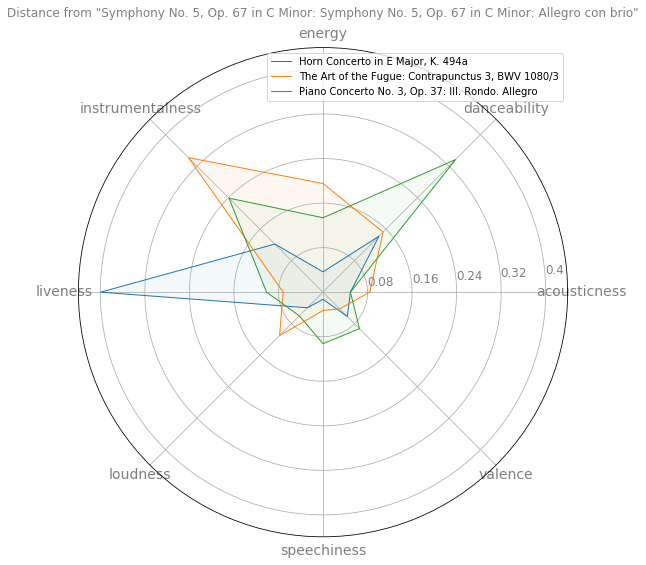

In [172]:
from math import pi, ceil

def spider_plot(df_with_titles):
    # number of variable
    df = df_with_titles.copy()
    df = df.drop(unwanted, axis=1)
    categories = df.columns
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    angles = np.array(angles)
    
    # Initialize the spider plot
    fig = plt.figure(figsize=(9, 9), edgecolor='gray')
    fig.patch.set_facecolor('none')
    fig.patch.set_alpha(0.0)
    ax = fig.add_subplot(111, polar=True)
    ax.patch.set_facecolor('none')
    ax.patch.set_alpha(0.0)
    
    # Get the audio features of the inputed song and repeat the first value at the end
    # We need to repeat the first value in each row of the dataframe to close the circular graph:
    song_values = df.iloc[0].values.flatten().tolist()
    song_values += song_values[:1]
    # convert back to numpy array because we're going to be doing math later
    song_values = np.array(song_values)
#     print("song values: ", song_values)

    # for use in setting the maximum y limit
    maximum_diff = 0
    
    # "3" is currently how many of the top 9 closest songs we are choosing to show
    for i in range(3): # put in how many of the top 9 you want there to be.
        
        # Again repeat the first value in the array to close the circle
        # skipping the first row, because that's the target song
        diff_values = df.iloc[i+1].values.flatten().tolist()
        diff_values += diff_values[:1]
        # convert back to numpy for math later on
        diff_values = np.array(diff_values)
#         print(f"\n song {i}", diff_values)

        # do the math we told you we were doing to do
        # this is the distance of each point from the user's chosen song
        diff_values = abs(song_values - diff_values)
#         print(f"\n difference {i}: ", diff_values)

        # plot the Data
        ax.plot(angles, diff_values, linewidth=1, linestyle='solid', label=df_with_titles.iloc[i+1]['track_name'])
        # fill the area of the newly drawn graph
        ax.fill(angles, diff_values, alpha=0.05)

        # check for new maximum y limit
        if max(diff_values) > maximum_diff:
            maximum_diff = max(diff_values)
        
    # Draw one axis per variable, add x labels
    plt.xticks(angles[:-1], categories, color='gray', size=14)
    
    # Draw ylabels    
    # set theta position to 0
    ax.set_rlabel_position(4)
    # make the tick lengths (and label names since the lengths are the labels)
    yticks = [round(0.2 * maximum_diff, 2), 
              round(0.4 * maximum_diff, 2), 
              round(0.6 * maximum_diff, 2), 
              round(0.8 * maximum_diff, 2), 
              round(1.0 * maximum_diff, 2)]
    plt.yticks(yticks, yticks, color = 'gray', fontsize=12)
    ax.spines['polar'].set_visible('False')
    # set maximum y limit to the largest prong of our web, 
    # that way the plot is exactly as big as it need to be, 
    # and no larger
    plt.ylim(0, 1.1 * maximum_diff)
#     print("\n maximum dif: ", maximum_diff)
    
    plt.title(f'Distance from "{df_with_titles.iloc[0].track_name}"', color='grey')
    
    # show the plot
    ax.legend()
    fig.savefig('temp.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()
    
    return None


spider_plot(df_norm.iloc[recommend])